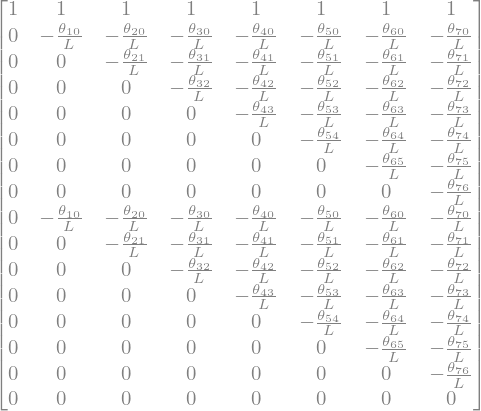

In [398]:
from sympy import *
import numpy as np

# create vector symbols v_{01}, v_{12},v_{23}...v_{(K-1)K}, two indices for each element
K = 7
L = symbols("L", positive=True)

tau = symbols("tau", real=True)
u_symbol = [symbols("u" + str(k), positive=True) for k in range(K)]
v_symbol = [symbols("v" + str(k) + str(k + 1), real=True) for k in range(K)]
vs_symbol = [symbols("v_*" + str(k), real=True) for k in range(K + 1)]

A = [symbols("A" + str(k), real=True) for k in range(0, K + 1)]


# create theta_k,i for k=0,..K-1, i=0,..k-1
theta = [
    [symbols("theta" + str(k) + str(i), real=True) for i in range(k)]
    for k in range(0, K + 1)
]

v = Matrix([v_symbol[i] for i in range(K)])
vs = Matrix([vs_symbol[i] for i in range(K + 1)])
u = Matrix([u_symbol[i] for i in range(K)])

# define unit vectors
f = eye(K + 1)
fs = zeros(K + 1, 1)

xs = zeros(2 * K + 2, 1)

e = zeros(2 * K + 2, K)
e[1 : K + 1, :] = eye(K)
g = zeros(2 * K + 2, K + 1)
g[K + 1 :, :] = eye(K + 1)
gs = zeros(2 * K + 2, 1)

# define  xi matrix (each column represents a xi vector)
xi = zeros(2 * K + 2, K + 1)
xi[0] = 1

for k in range(K):
    temp = xi[:, 0]
    for i in range(k + 1):
        temp = temp - 1 / L * theta[k + 1][i] * (e[:, i] + g[:, i])
    xi[:, k + 1] = temp

xi

In [399]:
# define linear constraint
func_linear = f[:, -1] + vs[K] * (fs - f[:, K])
for i in range(K):
    func_linear = func_linear + v[i] * (f[:, i] - f[:, i + 1]) + vs[i] * (fs - f[:, i])

# solve for the linear constraint == 0
sol_linear = solve(func_linear, vs)
sol_linear

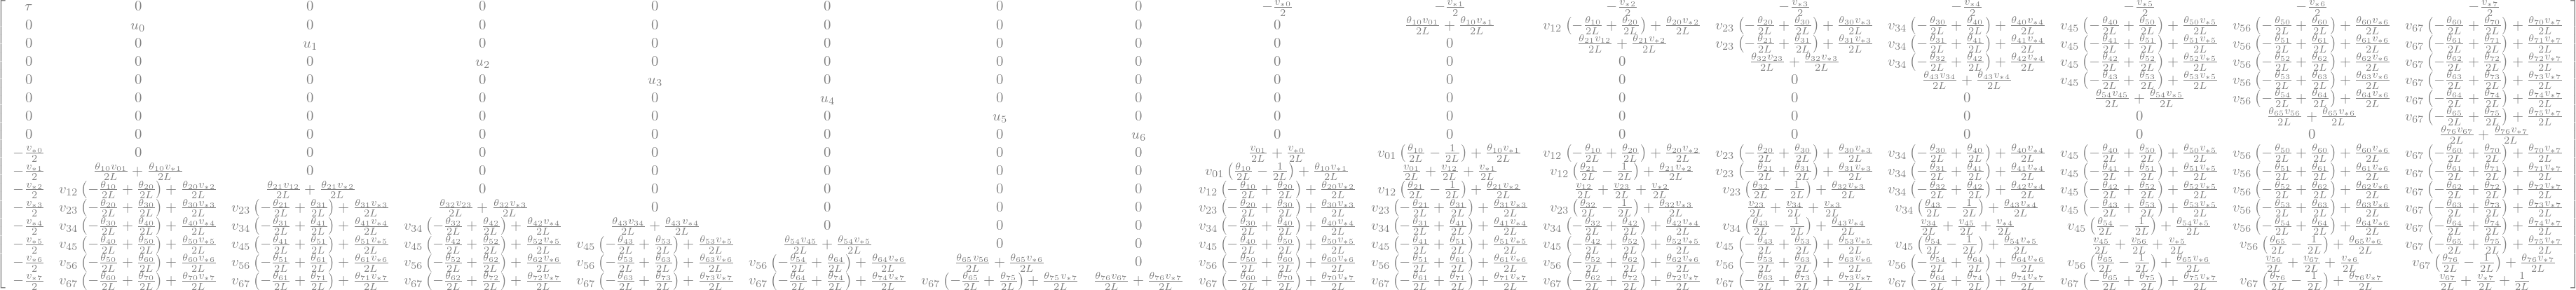

In [400]:
# define PSD constraint

func_PSD = tau * xi[:, 0] * xi[:, 0].T + 1 / (2 * L) * g[:, K] * g[:, K].T

for i in range(K):
    Aij = (
        Rational(1, 2)
        * (
            (xi[:, i] - xi[:, i + 1]) * g[:, i + 1].T
            + g[:, i + 1] * (xi[:, i] - xi[:, i + 1]).T
        )
        + 1 / (2 * L) * (g[:, i] - g[:, i + 1]) * (g[:, i] - g[:, i + 1]).T
    )
    Asi = (
        Rational(1, 2) * ((xs - xi[:, i]) * g[:, i].T + g[:, i] * (xs - xi[:, i]).T)
        + 1 / (2 * L) * (gs - g[:, i]) * (gs - g[:, i]).T
    )
    func_PSD = func_PSD + v[i] * Aij + vs[i] * Asi + u[i] * e[:, i] * e[:, i].T

i = K
Asi = (
    Rational(1, 2) * ((xs - xi[:, i]) * g[:, i].T + g[:, i] * (xs - xi[:, i]).T)
    + 1 / (2 * L) * (gs - g[:, i]) * (gs - g[:, i]).T
)
func_PSD = func_PSD + vs[i] * Asi

func_PSD

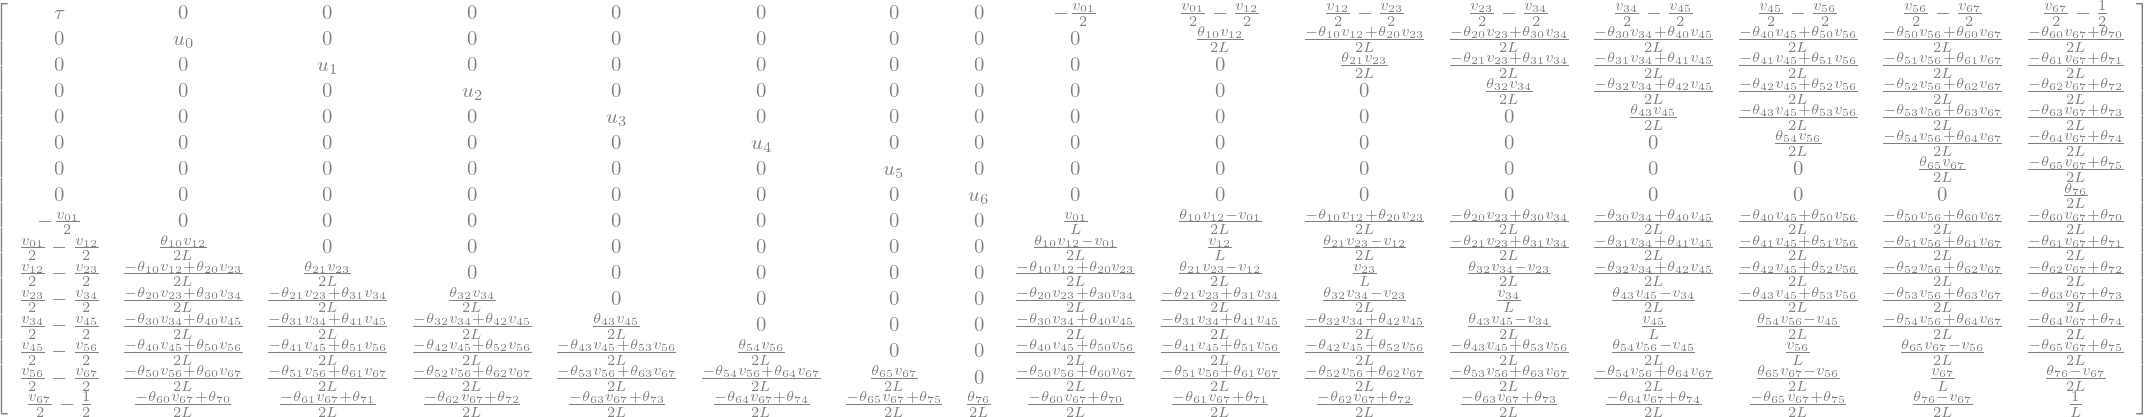

In [401]:
# substitute the solution of linear constraint
func_PSD = simplify(func_PSD.subs(sol_linear))
func_PSD

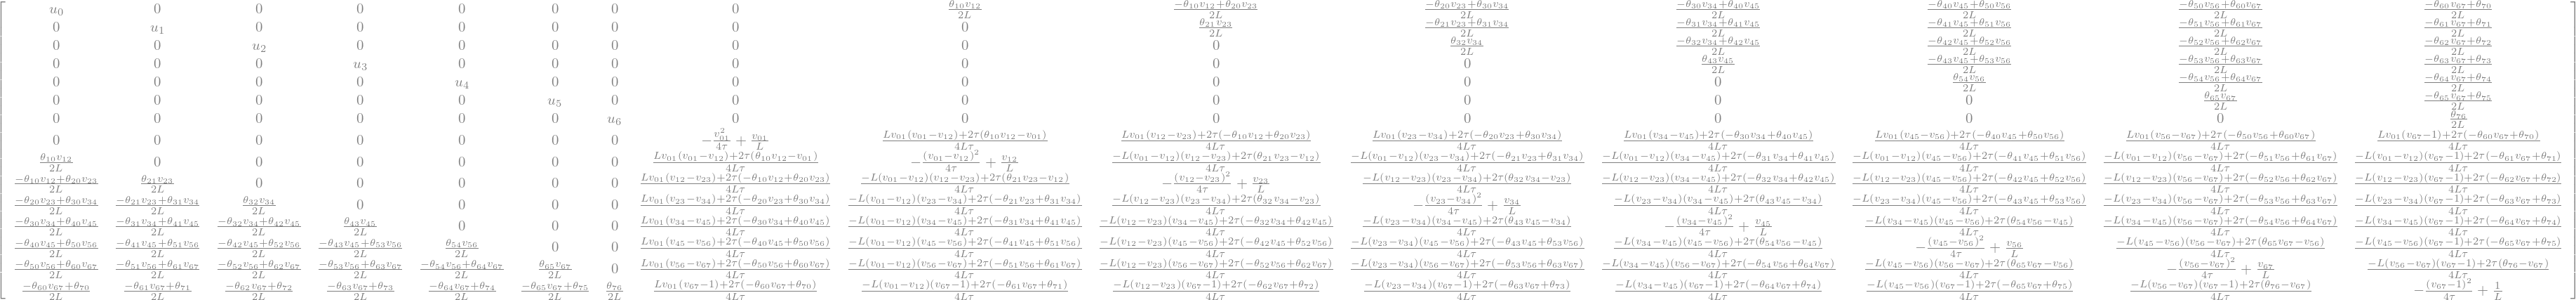

In [402]:
# Shur complement of tau

C = simplify(func_PSD[1:, 1:] - 1 / tau * func_PSD[1:, 0] * func_PSD[0, 1:])

C

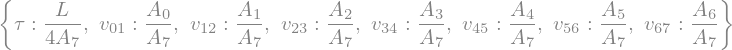

In [403]:
# insert OGM algorithm and corresponding dual variables
v_sub = {v[i]: A[i] / A[-1] for i in range(K)}
v_sub[tau] = L / A[-1] * Rational(1, 4)
v_sub

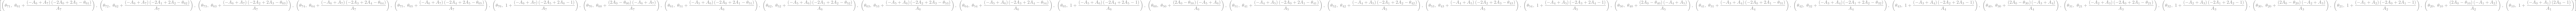

In [404]:
# use for loop to generate the above dictionary
theta_sub = []
for k in reversed(range(1, K + 1)):
    for i in range(1, k):

        if i == k - 1:
            theta_sub.append(
                (
                    theta[k][i],
                    1 + (2 * (A[k - 1] - A[k - 2]) - 1) * (A[k] - A[k - 1]) / A[k],
                )
            )
        else:
            theta_sub.append(
                (
                    theta[k][i],
                    (A[k] - A[k - 1]) / A[k] * (2 * (A[i] - A[i - 1]) - theta[k - 1][i])
                    + theta[k - 1][i],
                )
            )
    if k == 1:
        theta_sub.append(
            (theta[k][0], 1 + (2 * ((A[0] - 0)) - 1) * (A[k] - A[k - 1]) / A[k])
        )
    else:
        theta_sub.append(
            (
                theta[k][0],
                (A[k] - A[k - 1]) / A[k] * (2 * (A[0] - 0) - theta[k - 1][0])
                + theta[k - 1][0],
            )
        )


theta_sub

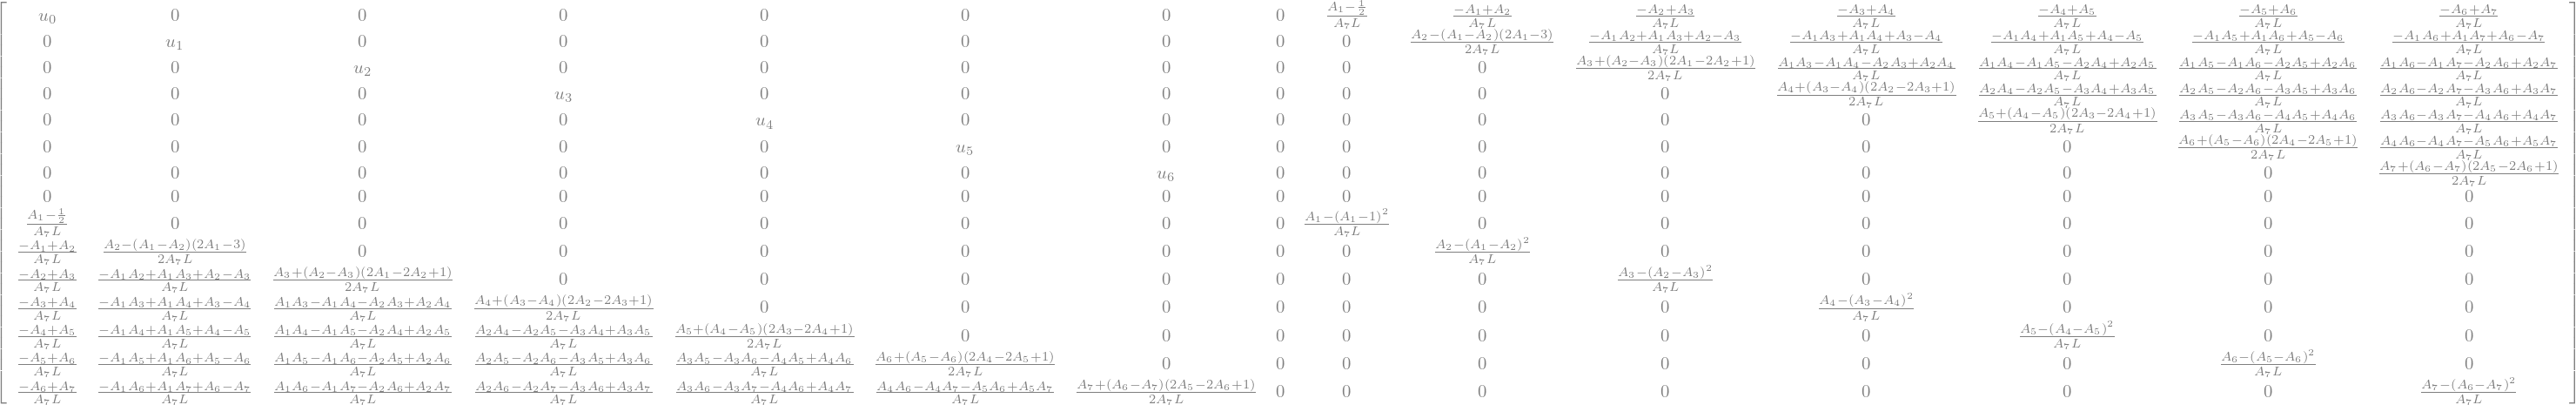

In [405]:
C_OGM = C.subs(v_sub).subs(theta_sub).subs({A[0]: 1})
C_OGM = simplify(C_OGM)
C_OGM

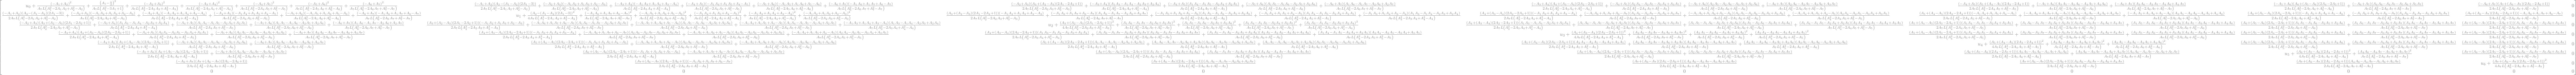

In [406]:
# Shur complement over lower right corner
D = (
    C_OGM[0 : K + 1, 0 : K + 1]
    - C_OGM[0 : K + 1, K + 1 :]
    * C_OGM[K + 1 :, K + 1 :].inv()
    * C_OGM[K + 1 :, 0 : K + 1]
)
D

In [417]:
# insert the value of A using OGM-a=4 algorithm
Aseq = 1
A_4 = [(A[0], Aseq)]
for i in range(1, K + 1):
    Aseq = Aseq + (i+4) / 4
    A_4.append((A[i], Aseq))
Dvalue = D.subs(A_4).subs({L: 1})
(Dvalue, np.sum(Dvalue, 0))

(Matrix([
 [u0 - 0.76615241621124,    -0.661478399051928,    -0.643517668605904,    -0.604250466853408,    -0.538463118580766,    -0.444187675070028,    -0.320448179271709, 0],
 [   -0.661478399051928, u1 - 0.97684799881491,     -0.80439708575738,     -0.75531308356676,    -0.673078898225957,    -0.555234593837535,    -0.400560224089636, 0],
 [   -0.643517668605904,     -0.80439708575738, u2 - 1.19604573367809,    -0.906375700280112,    -0.807694677871148,    -0.666281512605042,    -0.480672268907563, 0],
 [   -0.604250466853408,     -0.75531308356676,    -0.906375700280112, u3 - 1.38481926937442,     -0.94231045751634,    -0.777328431372549,     -0.56078431372549, 0],
 [   -0.538463118580766,    -0.673078898225957,    -0.807694677871148,     -0.94231045751634, u4 - 1.51692623716153,    -0.888375350140056,    -0.640896358543417, 0],
 [   -0.444187675070028,    -0.555234593837535,    -0.666281512605042,    -0.777328431372549,    -0.888375350140056, u5 - 1.56817226890756,    -0.721008403

In [419]:
# use lambda way to define Ak

# lambda_=[0.3 for i in range(K+1)]
# lambda_[-1]=0.9
lambda_ = [0.9, 0.4, 0.5, 0.2, 0.5, 0.3, 0.4, 0.9]
Aseq = 1
A_lambda = [(A[0], Aseq)]
for i in range(1, K + 1):
    Aseq = Aseq + 1 / 2 * (lambda_[i] + sqrt(4 * lambda_[i] * Aseq + lambda_[i] ** 2))
    A_lambda.append((A[i], Aseq))

A_lambda_seq = [A_lambda[i][1] for i in range(K + 1)]
A_lambda_seq


In [412]:
Dlambda = D.subs(A_lambda).subs(L, 1)
(Dlambda, np.sum(Dlambda, 0))

(Matrix([
 [u0 - 1.12939835373957,     -0.919551083925925,      -1.1757631429068,    -0.896385567992825,     -1.44031451920245,     -1.24315916844475,     -2.36559106043266, 0],
 [   -0.919551083925925, u1 - 0.890873043950243,     -1.01506566605153,    -0.773872032902927,     -1.24345947189962,     -1.07325033697325,     -2.04227380306135, 0],
 [     -1.1757631429068,      -1.01506566605153, u2 - 1.57080208186474,     -1.11786179580574,     -1.79618306279293,     -1.55031516585188,     -2.95007412589047, 0],
 [   -0.896385567992825,     -0.773872032902927,     -1.11786179580574, u3 - 1.00157828047663,     -1.28913166463873,     -1.11267075826987,     -2.11728639886149, 0],
 [    -1.44031451920245,      -1.24345947189962,     -1.79618306279293,     -1.28913166463873, u4 - 2.67352548500878,     -2.09731738374045,     -3.99095737682033, 0],
 [    -1.24315916844475,      -1.07325033697325,     -1.55031516585188,     -1.11267075826987,     -2.09731738374045, u5 - 2.15972909892044,       -3.

In [420]:
A_seq = A_lambda_seq
A_seq.append(0)
A_seq

In [437]:
N=100
L_num = 1

A_seq=[1]
temp = 1
for i in range(1,N+1):
    temp = temp + (i+4)/4
    A_seq.append(temp)
A_seq.append(0)

u_theoretical = [0 for i in range(N)]

for i in range(N):
    u = A_seq[i]*(1+2*(A_seq[i+1]-A_seq[i]))* (A_seq[i]+2*(A_seq[i]-A_seq[i-1])*(A_seq[i+1]-A_seq[i]))/(4*L_num * A_seq[N]*(A_seq[i+1]-(A_seq[i+1]-A_seq[i])**2))
    for k in range(i+1,N):
            u = u + A_seq[k]*(A_seq[i]-A_seq[i-1])*(A_seq[k+1]-A_seq[k])*(1+2*(A_seq[k+1]-A_seq[k])) / (2*L_num * A_seq[N]*(A_seq[k+1]-(A_seq[k+1]-A_seq[k])**2))
    
    u_theoretical[i] = u

u_theoretical